<a href="https://colab.research.google.com/github/shikharkyadesultory/GNN_resilient_network/blob/main/GCAT_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.8 MB/s eta 0:00:00


In [2]:
!pip install torch_scatter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch_scatter: filename=torch_scatter-2.1.2-cp312-cp312-linux_x86_64.whl size=640889 sha256=a97b0ec36ebf2b18fc4c44a2997acae6a181a024594a0e9be7cee1f4e241c71f
  Stored in directory: /root/.cache/pip/wheels/84/20/50/44800723f57cd798630e77b3ec83bc80bd26a1e3dc3a672ef5
Successfully built torch_scatter


#**Functionals for GCAT**

In [3]:
import torch
import math
import torch.nn as nn
import numpy as np

zeroTolerance = 1e-9
infiniteNumber = 1e12

### Functionals ##
def learnAttentionGSO(x, a, W, S, negative_slope=0.2):
  B = x.shape[0] #batch size
  G = x.shape[1] #input feature
  N = x.shape[2] #number of nodes
  P = a.shape[0] #number of heads
  E = a.shape[1] #edge features
  assert W.shape[0] == P
  assert W.shape[1] == E
  F = W.shape[2] ##output feature
  assert a.shape[2] == int(2*F)
  G = W.shape[3] #input feature
  assert S.shape[0] == E
  assert S.shape[1] == S.shape[2] == N #number of nodes

  ## adding ones of the GSO across all the edge features to make it self connected
  S = S + torch.eye(N).reshape([1,N,N]).repeat(E,1,1).to(S.device)
  x = x.reshape([B,1,1,G,N]) ## 1's included to compensate for the P & E
  W = W.reshape([1,P,E,F,G])
  Wx = torch.matmul(W,x) # B x P x E x F x N

  ## Now for the mixing parameter ##
  a1 = torch.index_select(a, 2, torch.arange(F).to(x.device)) ## 2 chosen to make it K x E x F
  a2 = torch.index_select(a, 2, torch.arange(F, 2*F).to(x.device)) # K x E x F
  ## Since there has to be a concatenation the and it has to be done across F so inner product is applied across that dimension
  a1Wx = torch.matmul(a1.reshape([1, P, E, 1, F]), Wx) # B x P x E x 1 x N
  a2Wx = torch.matmul(a2.reshape([1, P, E, 1, F]), Wx) # B x P x E x 1 x N
  aWx  = a1Wx + a2Wx.permute(0, 1, 2, 4, 3) # B x P x E x N x N
   ## We have one row and one column and we repeat them until both are of same size and then we add up
  eij = nn.functional.leaky_relu(aWx, negative_slope = negative_slope)
  ## Setting the places of no neighbor to -infinity so that it becomes zero before applying softmax
  maskEdges = torch.sum(torch.abs(S.data), dim=0) ##places of edges
  maskEdges = (maskEdges > zeroTolerance).type(x.dtype)
  infinityMask = (1-maskEdges) * infiniteNumber #making infinity for places of zero

  ## Attention sparsity through softmax
  #Forcing places of no edges to zero and then adding -infinity
  aij = nn.functional.softmax(eij*maskEdges - infinityMask, dim=4)
  return aij * maskEdges ## Reinforcinf zeros for backup

### Defining the graph attentional LSIGF ###
def GraphAttentionalLSIGF(h, x, a, W, S, b=None, negative_slope=0.2):
  E = h.shape[0] #Edge features
  K = h.shape[1] #Filter taps
  B = x.shape[0] #batch size
  G = x.shape[1] #input features
  N = x.shape[2] #number of nodes
  P = a.shape[0] #number of heads
  E = a.shape[1] #edge features
  assert W.shape[0] == P
  assert W.shape[1] == E
  F = W.shape[2] #out features
  assert W.shape[3] == G
  assert a.shape[2] == int(2*F)
  assert S.shape[0] == E
  assert S.shape[1] == S.shape[2] == N

  aij = learnAttentionGSO(x, a, W, S, negative_slope=negative_slope)
  h = h.reshape([1, 1, E, K, 1])
  W = W.permute(0, 3, 1, 2)
  W = W.reshape([P, F, E, 1, G])
  h = h * W # P x F x E x K x G
  x = x.reshape([B, 1, 1, G, N]) # B x P x E x G x N
  z = x.reshape([B, 1, 1, 1, G, N]).repeat(1, P, E, 1, 1, 1)
  for k in range(1,K):
    x = torch.matmul(x, aij) ##Adding across K in the B x P x E x G x N
    xAij = x.reshape([B, P, E, 1, G, N]) ##adding the k dimension
    z = torch.cat((z, xAij), dim=3)
  #output :- B x P x E x K x G x N
  h = h.reshape([1, P, F, E, K, G])
  # h = h.permute(0, 1, 2, 3, 4, 5)
  h = h.reshape([1, P, E*K*G, F])
  # h = h.permute(0 ,1, 3, 2)
  z = z.permute(0, 1, 5, 3, 2, 4).reshape([B, P, N, E*K*G])
  y = torch.matmul(z,h)
  y = y.permute(0, 1, 3, 2)
  if b is not None:
    y = y + b
  return y

class GraphFilterAttentional(nn.Module):
  def __init__(self, G,F, K, P, E=1, bias=True, nonlinearity=nn.functional.relu, concatenate=True):
    super().__init__()
    self.G = G
    self.F = F
    self.K = K
    self.P = P
    self.E = E
    self.S = None
    self.nonlinearity = nonlinearity
    self.concatenate = concatenate

    ##Creating parameters ##
    self.mixer = nn.parameter.Parameter(torch.Tensor(P, E, 2*F))
    self.weight = nn.parameter.Parameter(torch.Tensor(P, E, F, G))
    self.filterweight = nn.parameter.Parameter(torch.Tensor(E,K))
    if bias:
      self.bias = nn.parameter.Parameter(torch.Tensor(F , 1))
    else:
      self.register_parameter('bias', None)
    self.reset_parameters()

  def reset_parameters(self):
    stdv = 1. / math.sqrt(self.G * self.P)
    self.weight.data.uniform_(-stdv , stdv)
    self.mixer.data.uniform_(-stdv,stdv)
    self.filterweight.data.uniform_(-stdv,stdv)
    if self.bias is not None:
      self.bias.data.uniform_(-stdv,stdv)

  def addGSO(self, S):
    assert len(S.shape) == 3
    assert S.shape[0] == self.E
    self.N = S.shape[1]
    assert S.shape[2] == self.N
    self.S = S

  def forward(self, x):
      B = x.shape[0]
      F = x.shape[1]
      Nin = x.shape[2]

      ## Adding the zero padding
      if Nin < self.N :
          x = torch.cat((x, torch.zeros(B, F, self.N-Nin).type(x.dtype).to(x.device)), dim=2)

      y = GraphAttentionalLSIGF(self.filterweight, x, self.mixer, self.weight, self.S, b=self.bias)

      if self.concatenate:
          y = self.nonlinearity(y)
          y = y.permute(0, 3, 1, 2).reshape([B, self.N, self.P*self.F]).permute(0, 2, 1)
      else:
          y = torch.mean(y, dim=1)
          y = self.nonlinearity(y)

      if Nin < self.N:
          y = torch.index_select(y, 2, torch.arange(Nin).to(y.device))

      return y
  def extra_repr(self):
    reprString = "in_features=%d, " % self.G
    reprString += "out_features=%d, " % self.F
    reprString += "filter_taps=%d, " % self.K
    reprString += "attention_heads=%d, " % self.P
    reprString += "edge_features=%d, " % self.E
    reprString += "bias=%s, " % (self.bias is not None)
    if self.S is not None:
        reprString += "GSO stored: number_nodes=%d" % (self.N)
    else:
        reprString += "no GSO stored"
    return reprString

#**Graph Tools**

In [4]:
## Graph Tools ##
import torch
import torch.nn as nn
import numpy as np
## perm identity ##
def permIdentity(S):
  assert len(S.shape) == 2 or len(S.shape) == 3
  if len(S.shape) == 2:
    assert S.shape[0] == S.shape[1]
    S = S.reshape([1, S.shape[0], S.shape[1]])
    scalarWeights = True
  else:
    assert S.shape[1] == S.shape[2]
    scalarWeights = False
  N = S.shape[1]
  order = np.arange(N)
  if scalarWeights:
    S = S.reshape([N, N])
  return S, order.tolist()

def permDegree(S):
  assert len(S.shape) == 2 or len(S.shape) == 3
  scalarWeights = False
  if len(S.shape) == 2:
    assert S.shape[0] == S.shape[1]
    S = S.reshape([1, S.shape[0], S.shape[1]])
    scalarWeights = True
  else:
    assert S.shape[1] == S.shape[2]
    scalarWeights = False

  d = np.sum(np.sum(S, axis=1),axis = 0) ## computing the degree
  order = np.argsort(d)
  order = np.flip(order,0)
  S = S[:,order,:][:,:,order]
  if scalarWeights:
    S = S.reshape([S.shape[1],S.shape[2]])
  return S,order.tolist()

def changeDataType(x, dataType):
  if 'dtype' in dir(x):
    varType = x.dtype
  if 'numpy' in repr(dataType):
    if 'torch' in repr(varType):
      x = x.cpu().numpy().astype(dataType)
    elif 'numpy'in repr(type(x)):
      x = x.astype(dataType)
  elif 'torch' in repr(dataType):
    if 'torch' in repr(varType):
      x = x.type(dataType)
    elif 'numpy' in repr(type(x)):
      x = torch.tensor(x, dtype = dataType)
  return x

class AveragePooling(nn.Module):
  def __init__(self, n_in, n_out, alpha):
    super().__init__()
    self.alpha = alpha
    self.n_in = n_in
    self.n_out = n_out
  def forward(self, x):
    return torch.mean(x, dim=-1, keepdim=True)

#**Architecture for GCAT**

In [5]:
class GraphConvolutionAttentionalNetwork(nn.Module):
  def __init__(self, dimNodeSignals, nFilterTaps, nAttentionHeads, bias,
               nonlinearity, nSelectedNodes, poolingFunction, poolingSize,
               dimLayersMLP=None, dimLayersIPR=None, GSO=None, order=None):
    print("Initializing the GCAT GNN ......")
    try:
      super().__init__()
      assert len(dimNodeSignals) == len(nFilterTaps) + 1
      assert len(dimNodeSignals) == len(nAttentionHeads) + 1
      assert len(nSelectedNodes) == len(nAttentionHeads)
      assert len(poolingSize)    == len(nAttentionHeads)
      assert len(GSO.shape) == 2 or len(GSO.shape) == 3
      if len(GSO.shape) == 2:
        assert GSO.shape[0] == GSO.shape[1]
        GSO = GSO.reshape([1, GSO.shape[0], GSO.shape[1]])
      else:
        assert GSO.shape[1] == GSO.shape[2]
      self.L = len(nAttentionHeads) #number of graph filtering layers
      self.F = dimNodeSignals
      self.K = nFilterTaps
      self.P = nAttentionHeads
      self.E = GSO.shape[0]
      self.N = [GSO.shape[1]] + nSelectedNodes ##number of nodes in each layer

      if order is not None:
        self.permFunction = eval('perm' + order)
      else:
        self.permFunction = permIdentity
      self.S, self.order = self.permFunction(GSO)
      self.S = torch.tensor(self.S, dtype=torch.float32)
      if 'torch' not in repr(self.S.dtype):
        self.S = torch.tensor(self.S)
      self.sigma = nonlinearity
      self.alpha = poolingSize
      self.dimLayersMLP = dimLayersMLP if dimLayersMLP is not None else []
      self.dimLayersIPR = dimLayersIPR if dimLayersIPR is not None else []
      self.bias = bias
      self.rho = AveragePooling
      self.readout = nn.AdaptiveAvgPool1d(1)
      ## GAT layer ##
      gat = [] ## graph attentional layer
      if self.L > 1:
        #GAT first layer there are no attention heads increasing the number of features
        gat.append(GraphFilterAttentional(
            self.F[0],
            self.F[1],
            self.K[0],
            self.P[0],
            self.E,
            self.bias,
            self.sigma(),
            True))
        gat[0].addGSO(self.S)
        gat.append(self.rho(self.N[0], self.N[1], self.alpha[0]))
        # gat[1].addGSO(self.S)
        for l in range(1, self.L-1):
          gat.append(GraphFilterAttentional(self.F[l] * self.P[l-1],
                                            self.F[l+1],
                                            self.K[l],
                                            self.P[l],
                                            self.E,
                                            self.bias,
                                            self.sigma(),
                                            True))
          gat[2*l].addGSO(self.S) #Adding elements aftereach layer to the list
          gat.append(self.rho(self.N[l], self.N[l+1], self.alpha[l]))
          # gat[2*l+1].addGSO(self.S)
        gat.append(GraphFilterAttentional(self.F[self.L - 1] * self.P[self.L - 2],
                                          self.F[self.L],
                                          self.K[self.L - 1],
                                          self.P[self.L - 1],
                                          self.E,
                                          self.bias,
                                          self.sigma(),
                                          False))
        gat[2 * (self.L - 1)].addGSO(self.S)
        gat.append(self.rho(self.N[self.L - 1], self.N[self.L],self.alpha[self.L - 1]))
        # gat[2 * (self.L - 1) + 1].addGSO(self.S)
      else:
        gat.append(GraphFilterAttentional(self.F[0],self.F[1],self.K[0],self.P[0],self.E,self.bias,self.sigma(),False))
        gat[0].addGSO(self.S)
        gat.append(self.rho(self.N[0], self.N[1], self.alpha[0]))
        gat[1].addGSO(self.S)
      self.GCAT = nn.Sequential(*gat)
      ## MLP (Fully Connected Layer) ##
      fc = []
      if len(self.dimLayersMLP) > 0:
        # if str(self.sigma()).find('relu') >= 0:
        #   self.sigmaMLP = nn.ReLU()
        # elif str(self.sigma()).find('tanh') >= 0:
        #   self.sigmaMLP = nn.Tanh()
        # else:
        #   self.sigmaMLP = self.sigma()
        with torch.no_grad():
          test_input = torch.randn(1, self.F[0], self.N[0])
          test_output = self.GCAT(test_input)
          test_pooled = self.readout(test_output)
          test_pooled = test_pooled.squeeze(-1)
          dimInputMLP = test_pooled.shape[1]
          print(f"Actual MLP input dimension : {dimInputMLP}")

          # dimInputMLP = self.N[-1] * self.F[-1] #Flattening the vector
        fc.append(nn.Linear(dimInputMLP, dimLayersMLP[0], bias=self.bias))
        for l in range(len(dimLayersMLP) - 1):
          fc.append(self.sigma())
          fc.append(nn.Linear(dimLayersMLP[l], dimLayersMLP[l+1], bias=self.bias))
      self.MLP = nn.Sequential(*fc)

      ipr_layers = []
      ipr_input_dim = self.dimLayersMLP[-1] if self.dimLayersMLP else self.F[-1]
      if len(self.dimLayersIPR) > 0:
        ipr_layers.append(nn.Linear(ipr_input_dim, dimLayersMLP[0], bias=self.bias))
        for l in range(len(self.dimLayersMLP) - 1):
          ipr_layers.append(nn.Linear(dimLayersMLP[l], dimLayersMLP[l+1], bias=self.bias))
          if l < len(self.dimLayersMLP) - 2:
            ipr_layers.append(self.sigma())

        ipr_layers.append(self.sigma())
        ipr_layers.append(nn.Linear(dimLayersMLP[-1], 1, bias=self.bias))
      else:
        ipr_input_dim = self.dimLayersMLP[-1] if dimLayersMLP else self.F[-1]
        ipr_layers.append(nn.Linear(ipr_input_dim, 1, bias=self.bias))
      self.IPR_Regressor = nn.Sequential(*ipr_layers)
      print("GCAT_GNN __init__ completed successfully")
    except Exception as e:
      print(f"Erro in GCAT init {e}")
      import traceback
      traceback.print_exc()
      raise
  def forward(self, x):
    assert len(x.shape) == 3
    batchSize = x.shape[0]
    assert x.shape[1] == self.F[0]
    assert x.shape[2] == self.N[0]
    if self.S is not None:
      x = x[: , :, self.order] #B x F x N
    y = self.GCAT(x)
    y_pooled = self.readout(y)
    y_pooled = y_pooled.squeeze(-1)
    mlp_output = self.MLP(y_pooled) if self.dimLayersMLP else y_pooled
    ipr_output = self.IPR_Regressor(mlp_output)
    return mlp_output, ipr_output

  def to(self, device):
    super().to(device)
    self.S = self.S.to(device)
    for l in range(self.L):
      self.GCAT[2*l].addGSO(self.S)
    return self
      # self.GCAT[2*l + 1].addGSO(self.S)

#**Training Block -> GCAT**

In [6]:
def train_gcat_model(model, train_loader, val_loader, optimizer, criterion_cls, criterion_ipr,
                    epochs=100, device='cpu', cls_weight=1.0, ipr_weight=1.0):

    train_losses = {'total': [], 'cls': [], 'ipr': []}
    val_losses = {'total': [], 'cls': [], 'ipr': []}
    val_accuracies = []
    val_ipr_errors = []

    model.to(device)

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss_cls, train_loss_ipr = 0.0, 0.0

        for data, labels, ipr_targets in train_loader:
            data, labels, ipr_targets = data.to(device), labels.to(device), ipr_targets.to(device)

            optimizer.zero_grad()
            cls_output, ipr_output = model(data)

            loss_cls = criterion_cls(cls_output, labels)
            loss_ipr = criterion_ipr(ipr_output.squeeze(), ipr_targets)
            total_loss = cls_weight * loss_cls + ipr_weight * loss_ipr

            total_loss.backward()
            optimizer.step()

            train_loss_cls += loss_cls.item()
            train_loss_ipr += loss_ipr.item()

        # Validation
        model.eval()
        val_loss_cls, val_loss_ipr = 0.0, 0.0
        correct, total = 0, 0
        ipr_errors = []

        with torch.no_grad():
            for data, labels, ipr_targets in val_loader:
                data, labels, ipr_targets = data.to(device), labels.to(device), ipr_targets.to(device)
                cls_output, ipr_output = model(data)

                loss_cls = criterion_cls(cls_output, labels)
                loss_ipr = criterion_ipr(ipr_output.squeeze(), ipr_targets)

                val_loss_cls += loss_cls.item()
                val_loss_ipr += loss_ipr.item()

                _, predicted = torch.max(cls_output, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                ipr_errors.extend(torch.abs(ipr_output.squeeze() - ipr_targets).cpu().numpy())

        # Record metrics
        train_losses['cls'].append(train_loss_cls / len(train_loader))
        train_losses['ipr'].append(train_loss_ipr / len(train_loader))
        train_losses['total'].append((train_loss_cls + train_loss_ipr) / len(train_loader))

        val_losses['cls'].append(val_loss_cls / len(val_loader))
        val_losses['ipr'].append(val_loss_ipr / len(val_loader))
        val_losses['total'].append((val_loss_cls + val_loss_ipr) / len(val_loader))

        val_accuracies.append(100 * correct / total)
        val_ipr_errors.append(np.mean(ipr_errors))

        if epoch % 10 == 0:
            print(f'Epoch {epoch:3d}: Train Loss: {train_losses["total"][-1]:.4f} | '
                  f'Val Acc: {val_accuracies[-1]:.2f}% | Val IPR MAE: {val_ipr_errors[-1]:.4f}')

    return train_losses, val_losses, val_accuracies, val_ipr_errors

In [7]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import torch
def evaluate_gcat_model(model, test_loader, device='cpu'):
    """
    Evaluate GCAT model performance on test data
    """
    model.eval()

    all_preds = []
    all_labels = []
    all_ipr_preds = []
    all_ipr_actuals = []
    all_cls_probs = []

    with torch.no_grad():
        for data, labels, ipr_targets in test_loader:
            data, labels, ipr_targets = data.to(device), labels.to(device), ipr_targets.to(device)

            cls_output, ipr_output = model(data)

            # Classification predictions
            probs = torch.softmax(cls_output, dim=1)
            _, preds = torch.max(cls_output, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_cls_probs.extend(probs.cpu().numpy())

            # IPR predictions
            all_ipr_preds.extend(ipr_output.squeeze().cpu().numpy())
            all_ipr_actuals.extend(ipr_targets.cpu().numpy())

    # Convert to numpy arrays
    all_ipr_preds = np.array(all_ipr_preds)
    all_ipr_actuals = np.array(all_ipr_actuals)

    # Classification metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    # IPR regression metrics
    ipr_mae = mean_absolute_error(all_ipr_actuals, all_ipr_preds)
    ipr_rmse = np.sqrt(mean_squared_error(all_ipr_actuals, all_ipr_preds))
    ipr_r2 = r2_score(all_ipr_actuals, all_ipr_preds)
    ipr_corr = np.corrcoef(all_ipr_actuals, all_ipr_preds)[0, 1]

    return {
        # Classification results
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_cls_probs,

        # IPR regression results
        'ipr_predictions': all_ipr_preds,
        'ipr_actuals': all_ipr_actuals,
        'ipr_mae': ipr_mae,
        'ipr_rmse': ipr_rmse,
        'ipr_r2': ipr_r2,
        'ipr_correlation': ipr_corr,

        # Combined metrics
        'total_samples': len(all_labels)
    }

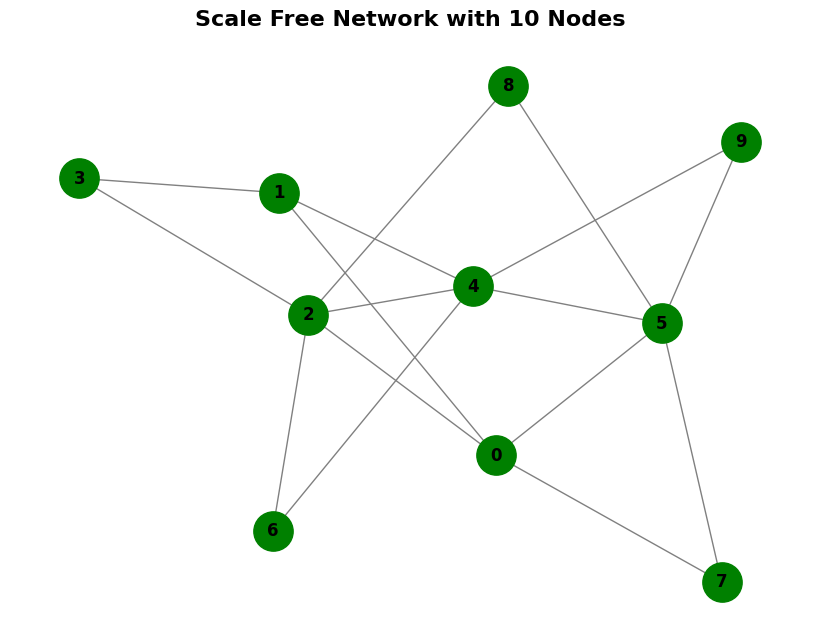

In [8]:
import networkx as nx
def create_scalefree_network(n_nodes, m=2, edge_weight=0.75):
  G = nx.barabasi_albert_graph(n_nodes, m) ## m portryaing the order for the no. of connections
  adj_matrix = nx.adjacency_matrix(G).todense()
  S = np.array(adj_matrix, dtype=float)
  S[S > 0] = edge_weight
  return S

n_nodes = 10
scalefree_adj = create_scalefree_network(n_nodes)
scalefree_graph = nx.from_numpy_array(scalefree_adj)

import matplotlib.pyplot as plt
plt.figure(figsize = (8,6))
pos = nx.spring_layout(scalefree_graph)
nx.draw(scalefree_graph,pos, with_labels=True, node_size=800, node_color='green',
        font_size=12, font_weight='bold', edge_color='gray')
plt.title(f"Scale Free Network with {n_nodes} Nodes", fontsize=16, fontweight='bold')
plt.savefig("scale_free_network.png", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
from torch_geometric.data import Dataset
import numpy as np
import torch

class ScaleFreeDataset(Dataset):
  def __init__(self, n_samples=1000, n_nodes=11, n_features=3, n_classes=2):
    self.n_samples = n_samples
    self.n_nodes = n_nodes
    self.n_features = n_features
    self.n_classes = n_classes
    self.adj_matrix = create_scalefree_network(n_nodes)
    self.data = []
    self.labels = []
    self.ipr_targets = []

    G = nx.from_numpy_array(self.adj_matrix)
    degree = np.array([deg for _,deg in G.degree()])
    hub_nodes = np.argsort(degree)[-2:] ## Top 2 hubs excluding the highest as index - 1
    for _ in range(n_samples):
      features = np.random.randn(n_features, n_nodes)
      ## Making the hubs nodes distinctive and scale-free specific
      for hub_idx in hub_nodes:
        features[:,hub_idx] += np.random.normal(2.0,1.0,n_features)
      n_modify = min(3,n_nodes)
      nodes_to_modify = np.random.choice(np.arange(n_nodes),size=n_modify,replace=False)

      hub_mean = np.mean(features[:,hub_nodes])
      non_hub_mean = np.mean(features[:,[i for i in range(n_nodes) if i not in hub_nodes]])
      label = int(abs(hub_mean - non_hub_mean) > 1.5)

      feature_magnitudes = np.linalg.norm(features, axis=0)
      squared = feature_magnitudes ** 2
      numerator = np.sum(squared** 2)
      denominator = np.sum(squared) ** 2
      ipr_value = numerator / denominator if denominator != 0 else 0.0

      ## Storing as torch tensors ##
      self.data.append(torch.tensor(features, dtype=torch.float64))
      self.labels.append(torch.tensor(label, dtype=torch.long))
      self.ipr_targets.append(ipr_value)


  def __len__(self):
    return self.n_samples

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx], torch.tensor(self.ipr_targets[idx], dtype=torch.float64)

#**Execution Block**

Using device: cpu
Initializing the GCAT GNN ......
Actual MLP input dimension : 8
GCAT_GNN __init__ completed successfully
GCAT Model parameters: 27,286
Training GCAT model...
Epoch   0: Train Loss: 3.2533 | Val Acc: 8.00% | Val IPR MAE: 0.0849
Epoch  10: Train Loss: 0.3336 | Val Acc: 92.00% | Val IPR MAE: 0.0335
Epoch  20: Train Loss: 0.2484 | Val Acc: 92.00% | Val IPR MAE: 0.0500
Epoch  30: Train Loss: 0.1396 | Val Acc: 97.33% | Val IPR MAE: 0.0338
Epoch  40: Train Loss: 0.1001 | Val Acc: 98.67% | Val IPR MAE: 0.0282
Epoch  50: Train Loss: 0.1104 | Val Acc: 98.00% | Val IPR MAE: 0.0287
Epoch  60: Train Loss: 0.0586 | Val Acc: 98.00% | Val IPR MAE: 0.0278
Epoch  70: Train Loss: 0.0842 | Val Acc: 97.33% | Val IPR MAE: 0.0282
Epoch  80: Train Loss: 0.0279 | Val Acc: 98.00% | Val IPR MAE: 0.0282
Epoch  90: Train Loss: 0.0172 | Val Acc: 98.67% | Val IPR MAE: 0.0299

Evaluating GCAT model on test set...

GCAT MODEL - FINAL RESULTS

📊 CLASSIFICATION METRICS:
Accuracy: 0.9400
F1 Score: 0.934

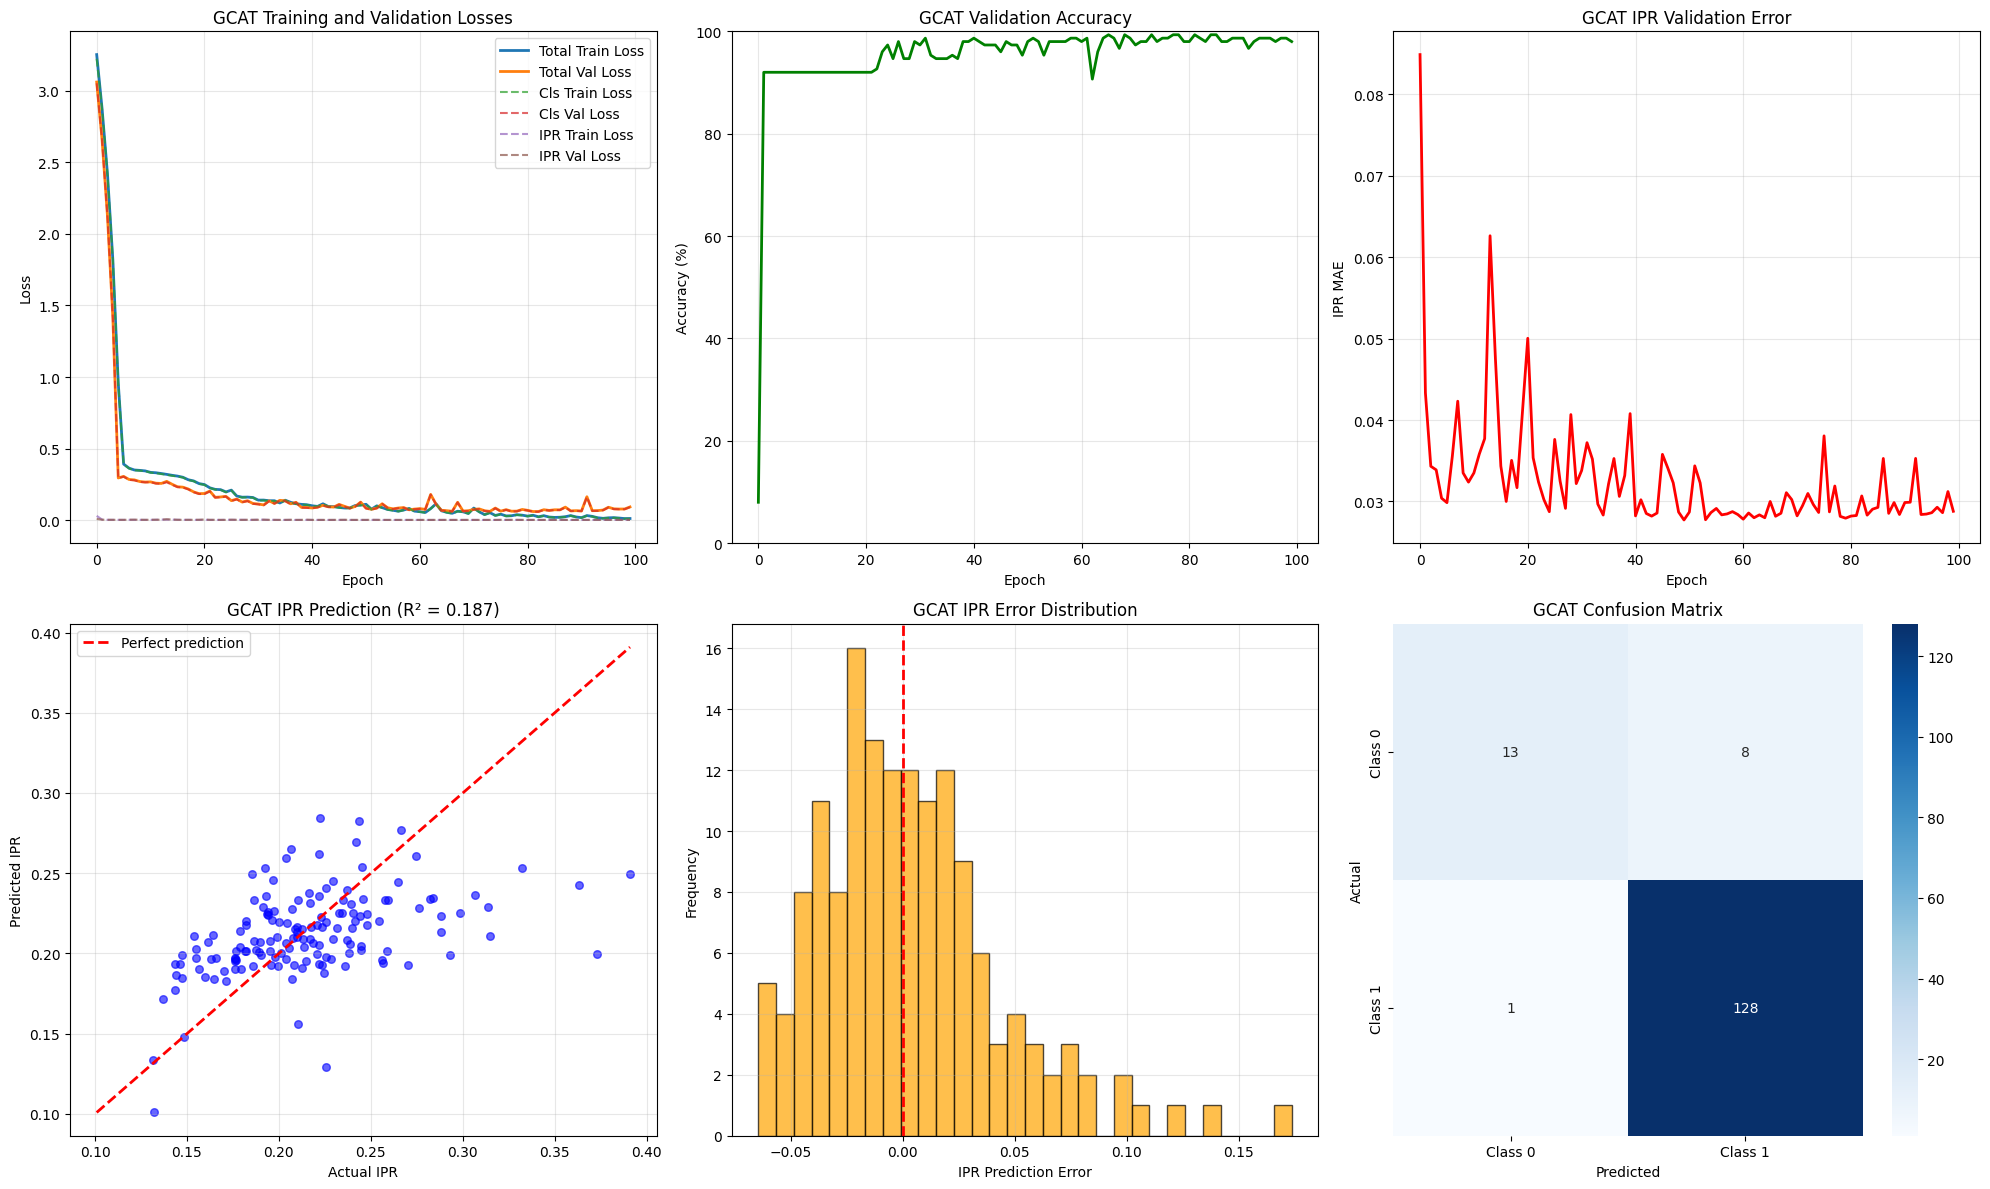


📋 GCAT DETAILED ANALYSIS:
Total samples: 150
IPR prediction range: [0.101, 0.284]
IPR actual range: [0.131, 0.391]
IPR error std: 0.0411

✅ GCAT results saved to 'gcat_model_results.pth'
✅ GCAT plot saved to 'gcat_model_results.png'


In [10]:
## Execution Block for GCAT GNN ##
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix
if __name__ == "__main__":
    # Set parameters
    n_nodes = 10
    n_features = 8
    n_classes = 2
    n_samples = 1000
    batch_size = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Using device: {device}")

    # Create dataset
    dataset = ScaleFreeDataset(n_samples=n_samples, n_nodes=n_nodes,
                             n_features=n_features, n_classes=n_classes)

    # Split dataset
    train_size = int(0.7 * n_samples)
    val_size = int(0.15 * n_samples)
    test_size = n_samples - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Create adjacency matrix
    adj_matrix = create_scalefree_network(n_nodes)

    # GCAT Model configuration
    model_config = {
        'dimNodeSignals': [n_features, 64, 32, 16, 8],  # Input, Hidden1, Hidden2, Hidden3, Output
        'nFilterTaps': [4, 3, 3, 3],                    # Filter taps for each layer
        'nAttentionHeads': [4, 2, 1, 1],                # Attention heads for each layer
        'bias': True,
        'nonlinearity': nn.ReLU,
        'nSelectedNodes': [50, 25, 10, 5],              # Nodes after each pooling
        'poolingFunction': AveragePooling,
        'poolingSize': [2, 2, 2, 2],                    # Pooling size for each layer
        'dimLayersMLP': [64, 32],                    # MLP layers after GCAT
        'dimLayersIPR': [16, 8],                     # IPR regression layers
        'GSO': adj_matrix,
        'order': 'Degree'
    }

    # Initialize GCAT model
    model = GraphConvolutionAttentionalNetwork(**model_config)
    model = model.double()
    model = model.to(device)

    print(f"GCAT Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Loss functions and optimizer
    criterion_cls = nn.CrossEntropyLoss()
    criterion_ipr = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Train the GCAT model
    print("Training GCAT model...")
    train_losses, val_losses, val_accuracies, val_ipr_errors = train_gcat_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion_cls=criterion_cls,
        criterion_ipr=criterion_ipr,
        epochs=100,
        device=device,
        cls_weight=1.0,
        ipr_weight=0.8
    )

    # Evaluate on test set
    print("\nEvaluating GCAT model on test set...")
    test_results = evaluate_gcat_model(
        model=model,
        test_loader=test_loader,
        device=device
    )

    # Print results
    print(f"\n{'='*50}")
    print("GCAT MODEL - FINAL RESULTS")
    print(f"{'='*50}")

    print(f"\n📊 CLASSIFICATION METRICS:")
    print(f"Accuracy: {test_results['accuracy']:.4f}")
    print(f"F1 Score: {test_results['f1_score']:.4f}")
    print(f"Precision: {test_results['precision']:.4f}")
    print(f"Recall: {test_results['recall']:.4f}")

    print(f"\n📈 IPR REGRESSION METRICS:")
    print(f"MAE: {test_results['ipr_mae']:.4f}")
    print(f"RMSE: {test_results['ipr_rmse']:.4f}")
    print(f"R² Score: {test_results['ipr_r2']:.4f}")
    print(f"Correlation: {test_results['ipr_correlation']:.4f}")

    # Generate comprehensive plots
    print("\nGenerating plots...")
    plt.figure(figsize=(20, 12))

    # Plot 1: Training and Validation Losses
    plt.subplot(2, 3, 1)
    plt.plot(train_losses['total'], label='Total Train Loss', linewidth=2)
    plt.plot(val_losses['total'], label='Total Val Loss', linewidth=2)
    plt.plot(train_losses['cls'], '--', label='Cls Train Loss', alpha=0.7)
    plt.plot(val_losses['cls'], '--', label='Cls Val Loss', alpha=0.7)
    plt.plot(train_losses['ipr'], '--', label='IPR Train Loss', alpha=0.7)
    plt.plot(val_losses['ipr'], '--', label='IPR Val Loss', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GCAT Training and Validation Losses')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Validation Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(val_accuracies, 'g-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('GCAT Validation Accuracy')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)

    # Plot 3: IPR Validation Error
    plt.subplot(2, 3, 3)
    plt.plot(val_ipr_errors, 'r-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('IPR MAE')
    plt.title('GCAT IPR Validation Error')
    plt.grid(True, alpha=0.3)

    # Plot 4: IPR Predictions vs Actual
    plt.subplot(2, 3, 4)
    plt.scatter(test_results['ipr_actuals'], test_results['ipr_predictions'],
                alpha=0.6, s=30, c='blue')
    min_val = min(np.min(test_results['ipr_actuals']), np.min(test_results['ipr_predictions']))
    max_val = max(np.max(test_results['ipr_actuals']), np.max(test_results['ipr_predictions']))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
    plt.xlabel('Actual IPR')
    plt.ylabel('Predicted IPR')
    plt.title(f'GCAT IPR Prediction (R² = {test_results["ipr_r2"]:.3f})')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 5: IPR Error Distribution
    plt.subplot(2, 3, 5)
    ipr_errors = test_results['ipr_actuals'] - test_results['ipr_predictions']
    plt.hist(ipr_errors, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel('IPR Prediction Error')
    plt.ylabel('Frequency')
    plt.title('GCAT IPR Error Distribution')
    plt.grid(True, alpha=0.3)

    # Plot 6: Confusion Matrix
    plt.subplot(2, 3, 6)
    cm = confusion_matrix(test_results['labels'], test_results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('GCAT Confusion Matrix')

    plt.tight_layout()
    plt.savefig('gcat_model_results_scalefree_3.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Additional analysis
    print(f"\n📋 GCAT DETAILED ANALYSIS:")
    print(f"Total samples: {test_results['total_samples']}")
    print(f"IPR prediction range: [{test_results['ipr_predictions'].min():.3f}, {test_results['ipr_predictions'].max():.3f}]")
    print(f"IPR actual range: [{test_results['ipr_actuals'].min():.3f}, {test_results['ipr_actuals'].max():.3f}]")
    print(f"IPR error std: {np.std(ipr_errors):.4f}")

    # Save results
    results_dict = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'val_ipr_errors': val_ipr_errors,
        'test_results': test_results,
        'model_config': model_config
    }

    torch.save({
        'model_state_dict': model.state_dict(),
        'results': results_dict
    }, 'gcat_model_results.pth')

    print(f"\n✅ GCAT results saved to 'gcat_model_results.pth'")
    print(f"✅ GCAT plot saved to 'gcat_model_results.png'")

#**Wheel Network**

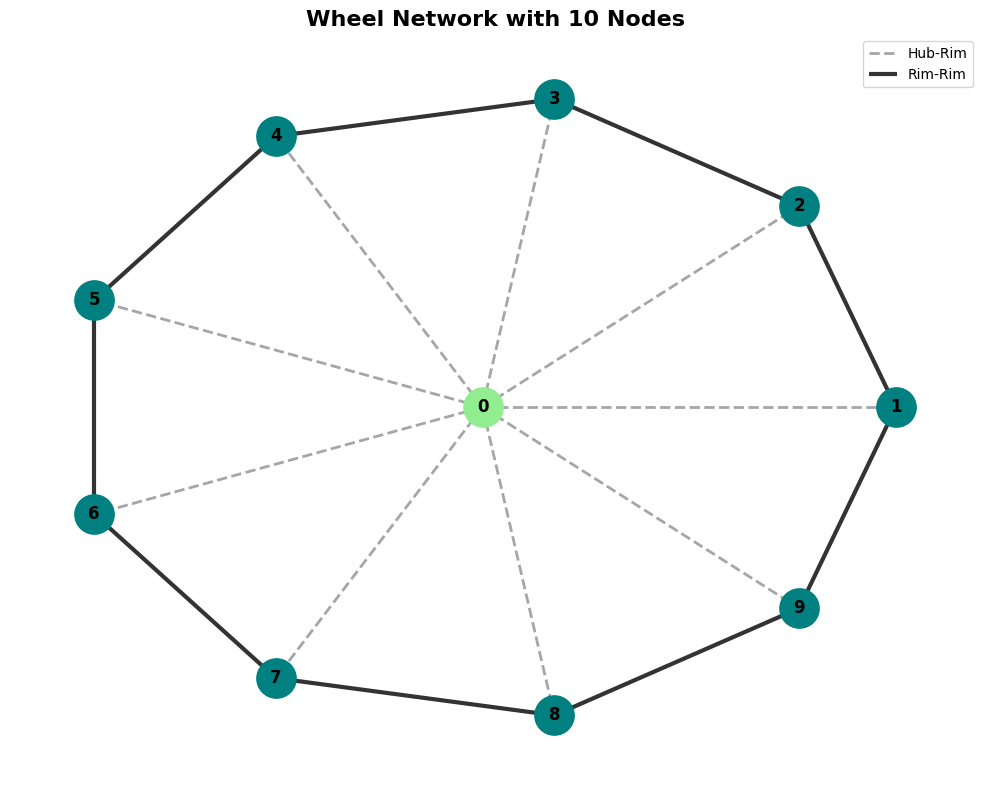

Adjacency Matrix:
[[0.5  0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]
 [0.75 0.5  0.75 0.   0.   0.   0.   0.   0.   0.75]
 [0.75 0.75 0.5  0.75 0.   0.   0.   0.   0.   0.  ]
 [0.75 0.   0.75 0.5  0.75 0.   0.   0.   0.   0.  ]
 [0.75 0.   0.   0.75 0.5  0.75 0.   0.   0.   0.  ]
 [0.75 0.   0.   0.   0.75 0.5  0.75 0.   0.   0.  ]
 [0.75 0.   0.   0.   0.   0.75 0.5  0.75 0.   0.  ]
 [0.75 0.   0.   0.   0.   0.   0.75 0.5  0.75 0.  ]
 [0.75 0.   0.   0.   0.   0.   0.   0.75 0.5  0.75]
 [0.75 0.75 0.   0.   0.   0.   0.   0.   0.75 0.5 ]]


In [11]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def create_wheel_network(n_nodes, center_weight=1, edge_weight=0.75):
  S = np.zeros((n_nodes, n_nodes))
  rim_nodes = list(range(1,n_nodes))
  hub_idx = 0

  for i in rim_nodes:
    S[hub_idx, i] = edge_weight
    S[i, hub_idx] = edge_weight

  for i in range(len(rim_nodes)):
    current = rim_nodes[i]
    next_node = rim_nodes[(i + 1) % len(rim_nodes)]
    S[current, next_node] = edge_weight
    S[next_node, current] = edge_weight

  np.fill_diagonal(S , 0.5)
  return S
n_nodes = 10
adj_matrix = create_wheel_network(n_nodes)
G = nx.from_numpy_array(adj_matrix)
plt.figure(figsize = (10,8))
pos = {}
hub_idx = 0
rim_nodes = list(range(1,n_nodes))
pos[hub_idx] = np.array([0,0])

angles = np.linspace(0 , 2 *  np.pi, len(rim_nodes), endpoint=False)
for i,node in enumerate(rim_nodes):
  radius = 1.0
  x = radius * np.cos(angles[i])
  y = radius * np.sin(angles[i])
  pos[node] = np.array([x,y])
hub_color = 'lightgreen'
rim_color = 'teal'
nx.draw_networkx_nodes(G, pos, nodelist=[hub_idx], node_color=hub_color, node_size=800)
nx.draw_networkx_nodes(G, pos, nodelist=rim_nodes, node_color=rim_color, node_size=800)
hub_rim_edges = [(hub_idx, i) for i in rim_nodes]
rim_rim_edges = [(rim_nodes[i], rim_nodes[(i + 1) % len(rim_nodes)]) for i in range(len(rim_nodes))]

nx.draw_networkx_edges(G, pos, edgelist=hub_rim_edges,
                       edge_color='gray', width=2, alpha=0.7,
                       style='dashed', label='Hub-Rim')

nx.draw_networkx_edges(G, pos, edgelist=rim_rim_edges,
                       edge_color='black', width=3, alpha=0.8,
                       label='Rim-Rim')

nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

plt.title(f"Wheel Network with {n_nodes} Nodes", fontsize=16, fontweight='bold')
plt.legend(loc='best')
plt.axis('off')
plt.tight_layout()

plt.savefig("wheel_network.png", dpi=300, bbox_inches='tight')
plt.show()

print("Adjacency Matrix:")
print(adj_matrix)

In [12]:
from torch_geometric.data import Dataset
import numpy as np
import torch

class WheelNetworkDataset(Dataset):
  def __init__(self,n_samples=1000, n_nodes=11, n_features=3, n_classes=2):
    self.n_samples = n_samples
    self.n_nodes = n_nodes
    self.n_features = n_features
    self.n_classes = n_classes
    self.adj_matrix = create_wheel_network(n_nodes)
    self.data = []
    self.labels = []
    self.ipr_targets = []

    for _ in range(n_samples):
      features = np.random.randn(n_features, n_nodes)
      features[:,0] += np.random.normal(2.0,1.0, n_features)
      num_nodes_to_modify = min(3, n_nodes - 1)
      perimeter_nodes_to_modify = np.random.choice(np.arange(1, n_nodes), size=num_nodes_to_modify, replace=False)
      for node_idx in perimeter_nodes_to_modify:
        features[:,node_idx] += np.random.choice([-3.0,3.0], size=n_features) # Changed to float for consistency

      ## Defining the labels based on hub and rim features ##
      hub_features = np.mean(features[:,0])
      # Fix: Correctly calculate rim features based on the selected modified nodes
      rim_features = features[:,perimeter_nodes_to_modify]
      label = int(np.abs(hub_features - np.mean(rim_features)) > 2.0)

      ## IPR calculation setup ##
      feature_magnitudes = np.linalg.norm(features, axis=0)
      squared = feature_magnitudes ** 2
      numeratr = np.sum(squared ** 2)
      denominator = np.sum(squared) ** 2
      ipr_value = numeratr / denominator if denominator != 0 else 0.0

      self.data.append(features)
      self.labels.append(label)
      self.ipr_targets.append(ipr_value)
  def __len__(self):
    return self.n_samples

  def __getitem__(self,idx):
    return self.data[idx], self.labels[idx], torch.tensor(self.ipr_targets[idx], dtype=torch.float64)

#**Execution Block - Wheel**

Using device: cpu
Initializing the GCAT GNN ......
Actual MLP input dimension : 8
GCAT_GNN __init__ completed successfully
GCAT Model parameters: 27,282
Training GCAT model...
Epoch   0: Train Loss: 3.3350 | Val Acc: 48.00% | Val IPR MAE: 0.0300
Epoch  10: Train Loss: 0.6462 | Val Acc: 72.00% | Val IPR MAE: 0.0391
Epoch  20: Train Loss: 0.5965 | Val Acc: 72.67% | Val IPR MAE: 0.0123
Epoch  30: Train Loss: 0.5980 | Val Acc: 74.00% | Val IPR MAE: 0.0144
Epoch  40: Train Loss: 0.5858 | Val Acc: 72.67% | Val IPR MAE: 0.0160
Epoch  50: Train Loss: 0.5983 | Val Acc: 73.33% | Val IPR MAE: 0.0204
Epoch  60: Train Loss: 0.5779 | Val Acc: 73.33% | Val IPR MAE: 0.0125
Epoch  70: Train Loss: 0.5802 | Val Acc: 72.67% | Val IPR MAE: 0.0175
Epoch  80: Train Loss: 0.5765 | Val Acc: 74.00% | Val IPR MAE: 0.0131
Epoch  90: Train Loss: 0.5777 | Val Acc: 71.33% | Val IPR MAE: 0.0135

Evaluating GCAT model on test set...

GCAT MODEL - FINAL RESULTS

 CLASSIFICATION METRICS:
Accuracy: 0.6800
F1 Score: 0.679

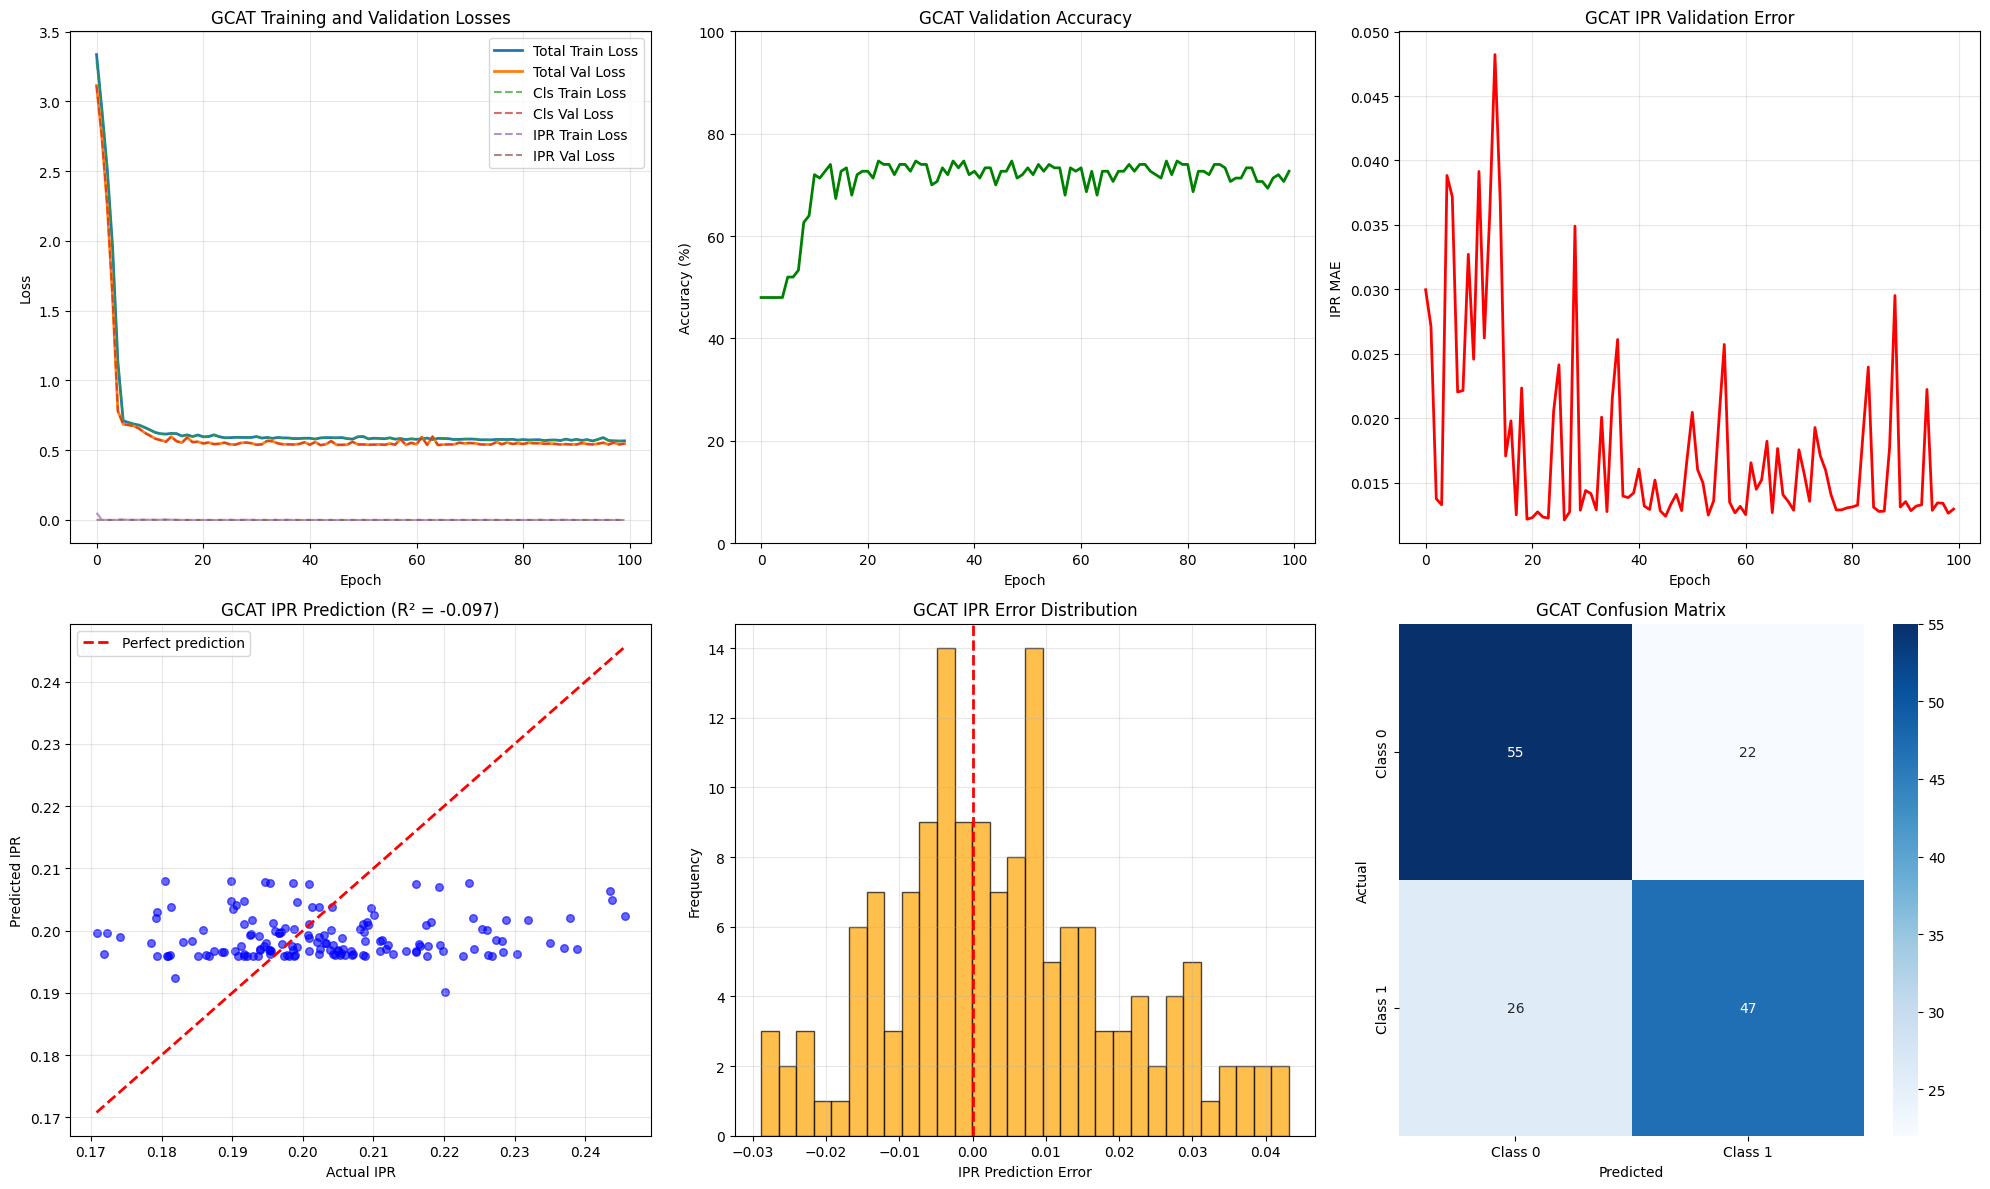


 GCAT DETAILED ANALYSIS:
Total samples: 150
IPR prediction range: [0.190, 0.208]
IPR actual range: [0.171, 0.246]
IPR error std: 0.0158

 GCAT results saved to 'gcat_model_results.pth'
 GCAT plot saved to 'gcat_model_results.png'


In [27]:
## Execution Block for GCAT GNN ##
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix
if __name__ == "__main__":
    # Set parameters
    n_nodes = 10
    n_features = 8
    n_classes = 2
    n_samples = 1000
    batch_size = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Using device: {device}")

    # Create dataset
    dataset = WheelNetworkDataset(n_samples=n_samples, n_nodes=n_nodes,
                             n_features=n_features, n_classes=n_classes)

    # Split dataset
    train_size = int(0.7 * n_samples)
    val_size = int(0.15 * n_samples)
    test_size = n_samples - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Create adjacency matrix
    adj_matrix = create_wheel_network(n_nodes)

    # GCAT Model configuration
    model_config = {
        'dimNodeSignals': [n_features, 64, 32, 16, 8],  # Input, Hidden1, Hidden2, Output
        'nFilterTaps': [3, 2, 2, 2],                    # Filter taps for each layer
        'nAttentionHeads': [4, 2, 1, 1],                # Attention heads for each layer
        'bias': True,
        'nonlinearity': nn.ReLU,
        'nSelectedNodes': [50, 25, 10, 5],              # Nodes after each pooling
        'poolingFunction': AveragePooling,
        'poolingSize': [2, 2, 2, 2],                    # Pooling size for each layer
        'dimLayersMLP': [64, 32],                    # MLP layers after GCAT
        'dimLayersIPR': [16, 8],                     # IPR regression layers
        'GSO': adj_matrix,
        'order': 'Degree'
    }

    # Initialize GCAT model
    model = GraphConvolutionAttentionalNetwork(**model_config)
    model = model.double()
    model = model.to(device)

    print(f"GCAT Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Loss functions and optimizer
    criterion_cls = nn.CrossEntropyLoss()
    criterion_ipr = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Train the GCAT model
    print("Training GCAT model...")
    train_losses, val_losses, val_accuracies, val_ipr_errors = train_gcat_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion_cls=criterion_cls,
        criterion_ipr=criterion_ipr,
        epochs=100,
        device=device,
        cls_weight=1.0,
        ipr_weight=0.8
    )

    # Evaluate on test set
    print("\nEvaluating GCAT model on test set...")
    test_results = evaluate_gcat_model(
        model=model,
        test_loader=test_loader,
        device=device
    )

    # Print results
    print(f"\n{'='*50}")
    print("GCAT MODEL - FINAL RESULTS")
    print(f"{'='*50}")

    print(f"\n CLASSIFICATION METRICS:")
    print(f"Accuracy: {test_results['accuracy']:.4f}")
    print(f"F1 Score: {test_results['f1_score']:.4f}")
    print(f"Precision: {test_results['precision']:.4f}")
    print(f"Recall: {test_results['recall']:.4f}")

    print(f"\n IPR REGRESSION METRICS:")
    print(f"MAE: {test_results['ipr_mae']:.4f}")
    print(f"RMSE: {test_results['ipr_rmse']:.4f}")
    print(f"R² Score: {test_results['ipr_r2']:.4f}")
    print(f"Correlation: {test_results['ipr_correlation']:.4f}")

    # Generate comprehensive plots
    print("\nGenerating plots...")
    plt.figure(figsize=(20, 12))

    # Plot 1: Training and Validation Losses
    plt.subplot(2, 3, 1)
    plt.plot(train_losses['total'], label='Total Train Loss', linewidth=2)
    plt.plot(val_losses['total'], label='Total Val Loss', linewidth=2)
    plt.plot(train_losses['cls'], '--', label='Cls Train Loss', alpha=0.7)
    plt.plot(val_losses['cls'], '--', label='Cls Val Loss', alpha=0.7)
    plt.plot(train_losses['ipr'], '--', label='IPR Train Loss', alpha=0.7)
    plt.plot(val_losses['ipr'], '--', label='IPR Val Loss', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GCAT Training and Validation Losses')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Validation Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(val_accuracies, 'g-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('GCAT Validation Accuracy')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)

    # Plot 3: IPR Validation Error
    plt.subplot(2, 3, 3)
    plt.plot(val_ipr_errors, 'r-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('IPR MAE')
    plt.title('GCAT IPR Validation Error')
    plt.grid(True, alpha=0.3)

    # Plot 4: IPR Predictions vs Actual
    plt.subplot(2, 3, 4)
    plt.scatter(test_results['ipr_actuals'], test_results['ipr_predictions'],
                alpha=0.6, s=30, c='blue')
    min_val = min(np.min(test_results['ipr_actuals']), np.min(test_results['ipr_predictions']))
    max_val = max(np.max(test_results['ipr_actuals']), np.max(test_results['ipr_predictions']))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
    plt.xlabel('Actual IPR')
    plt.ylabel('Predicted IPR')
    plt.title(f'GCAT IPR Prediction (R² = {test_results["ipr_r2"]:.3f})')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 5: IPR Error Distribution
    plt.subplot(2, 3, 5)
    ipr_errors = test_results['ipr_actuals'] - test_results['ipr_predictions']
    plt.hist(ipr_errors, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel('IPR Prediction Error')
    plt.ylabel('Frequency')
    plt.title('GCAT IPR Error Distribution')
    plt.grid(True, alpha=0.3)

    # Plot 6: Confusion Matrix
    plt.subplot(2, 3, 6)
    cm = confusion_matrix(test_results['labels'], test_results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('GCAT Confusion Matrix')

    plt.tight_layout()
    plt.savefig('gcat_model_results_wheel_3.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Additional analysis
    print(f"\n GCAT DETAILED ANALYSIS:")
    print(f"Total samples: {test_results['total_samples']}")
    print(f"IPR prediction range: [{test_results['ipr_predictions'].min():.3f}, {test_results['ipr_predictions'].max():.3f}]")
    print(f"IPR actual range: [{test_results['ipr_actuals'].min():.3f}, {test_results['ipr_actuals'].max():.3f}]")
    print(f"IPR error std: {np.std(ipr_errors):.4f}")

    # Save results
    results_dict = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'val_ipr_errors': val_ipr_errors,
        'test_results': test_results,
        'model_config': model_config
    }

    torch.save({
        'model_state_dict': model.state_dict(),
        'results': results_dict
    }, 'gcat_model_results.pth')

    print(f"\n GCAT results saved to 'gcat_model_results.pth'")
    print(f" GCAT plot saved to 'gcat_model_results.png'")

#**Star Network**

In [28]:
def create_star_network(n_nodes, center_weight=1, edge_weight=0.75):
  S = np.zeros((n_nodes, n_nodes))
  center_idx = 0
  for i in range(1,n_nodes):
    S[center_idx, i] = edge_weight
    S[i, center_idx] = edge_weight

  np.fill_diagonal(S , 0.5)
  return S
from torch_geometric.data import Dataset
class StarNetworkDataset(Dataset):
  def __init__(self,n_samples=1000, n_nodes=10, n_features=3, n_classes=2):
    self.n_samples = n_samples
    self.n_nodes = n_nodes
    self.n_features = n_features
    self.n_classes = n_classes
    self.adj_matrix = create_star_network(n_nodes)
    self.data = []
    self.labels = []
    self.ipr_targets = []

    for _ in range(n_samples):
      features = np.random.randn(n_features, n_nodes)
      features[:,0] += np.random.choice([-2,2], size=n_features)
      label = int(np.mean(features[:,0]) > 0)

      ## Calculate IPR target ##
      node_features_for_ipr = features[0]
      squared = node_features_for_ipr ** 2
      numeratr = np.sum(squared ** 2)
      denominator = np.sum(squared) ** 2
      ipr_value = numeratr / denominator if denominator != 0 else 0.0

      self.data.append(features)
      self.labels.append(label)
      self.ipr_targets.append(ipr_value)

  def __len__(self):
    return self.n_samples

  def __getitem__(self,idx):
    return self.data[idx], self.labels[idx], torch.tensor(self.ipr_targets[idx], dtype=torch.float64)

#**Evaluation Block**

Using device: cpu
Initializing the GCAT GNN ......
Actual MLP input dimension : 8
GCAT_GNN __init__ completed successfully
GCAT Model parameters: 27,283
Training GCAT model...
Epoch   0: Train Loss: 3.4890 | Val Acc: 42.67% | Val IPR MAE: 0.0816
Epoch  10: Train Loss: 0.6615 | Val Acc: 70.67% | Val IPR MAE: 0.0856
Epoch  20: Train Loss: 0.4194 | Val Acc: 92.00% | Val IPR MAE: 0.0957
Epoch  30: Train Loss: 0.1355 | Val Acc: 96.67% | Val IPR MAE: 0.0765
Epoch  40: Train Loss: 0.0617 | Val Acc: 99.33% | Val IPR MAE: 0.1151
Epoch  50: Train Loss: 0.0231 | Val Acc: 99.33% | Val IPR MAE: 0.0840
Epoch  60: Train Loss: 0.0164 | Val Acc: 99.33% | Val IPR MAE: 0.0782
Epoch  70: Train Loss: 0.0136 | Val Acc: 98.67% | Val IPR MAE: 0.0741
Epoch  80: Train Loss: 0.0126 | Val Acc: 98.00% | Val IPR MAE: 0.0794
Epoch  90: Train Loss: 0.0122 | Val Acc: 98.00% | Val IPR MAE: 0.0797

Evaluating GCAT model on test set...

GCAT MODEL - FINAL RESULTS

 CLASSIFICATION METRICS:
Accuracy: 0.9667
F1 Score: 0.966

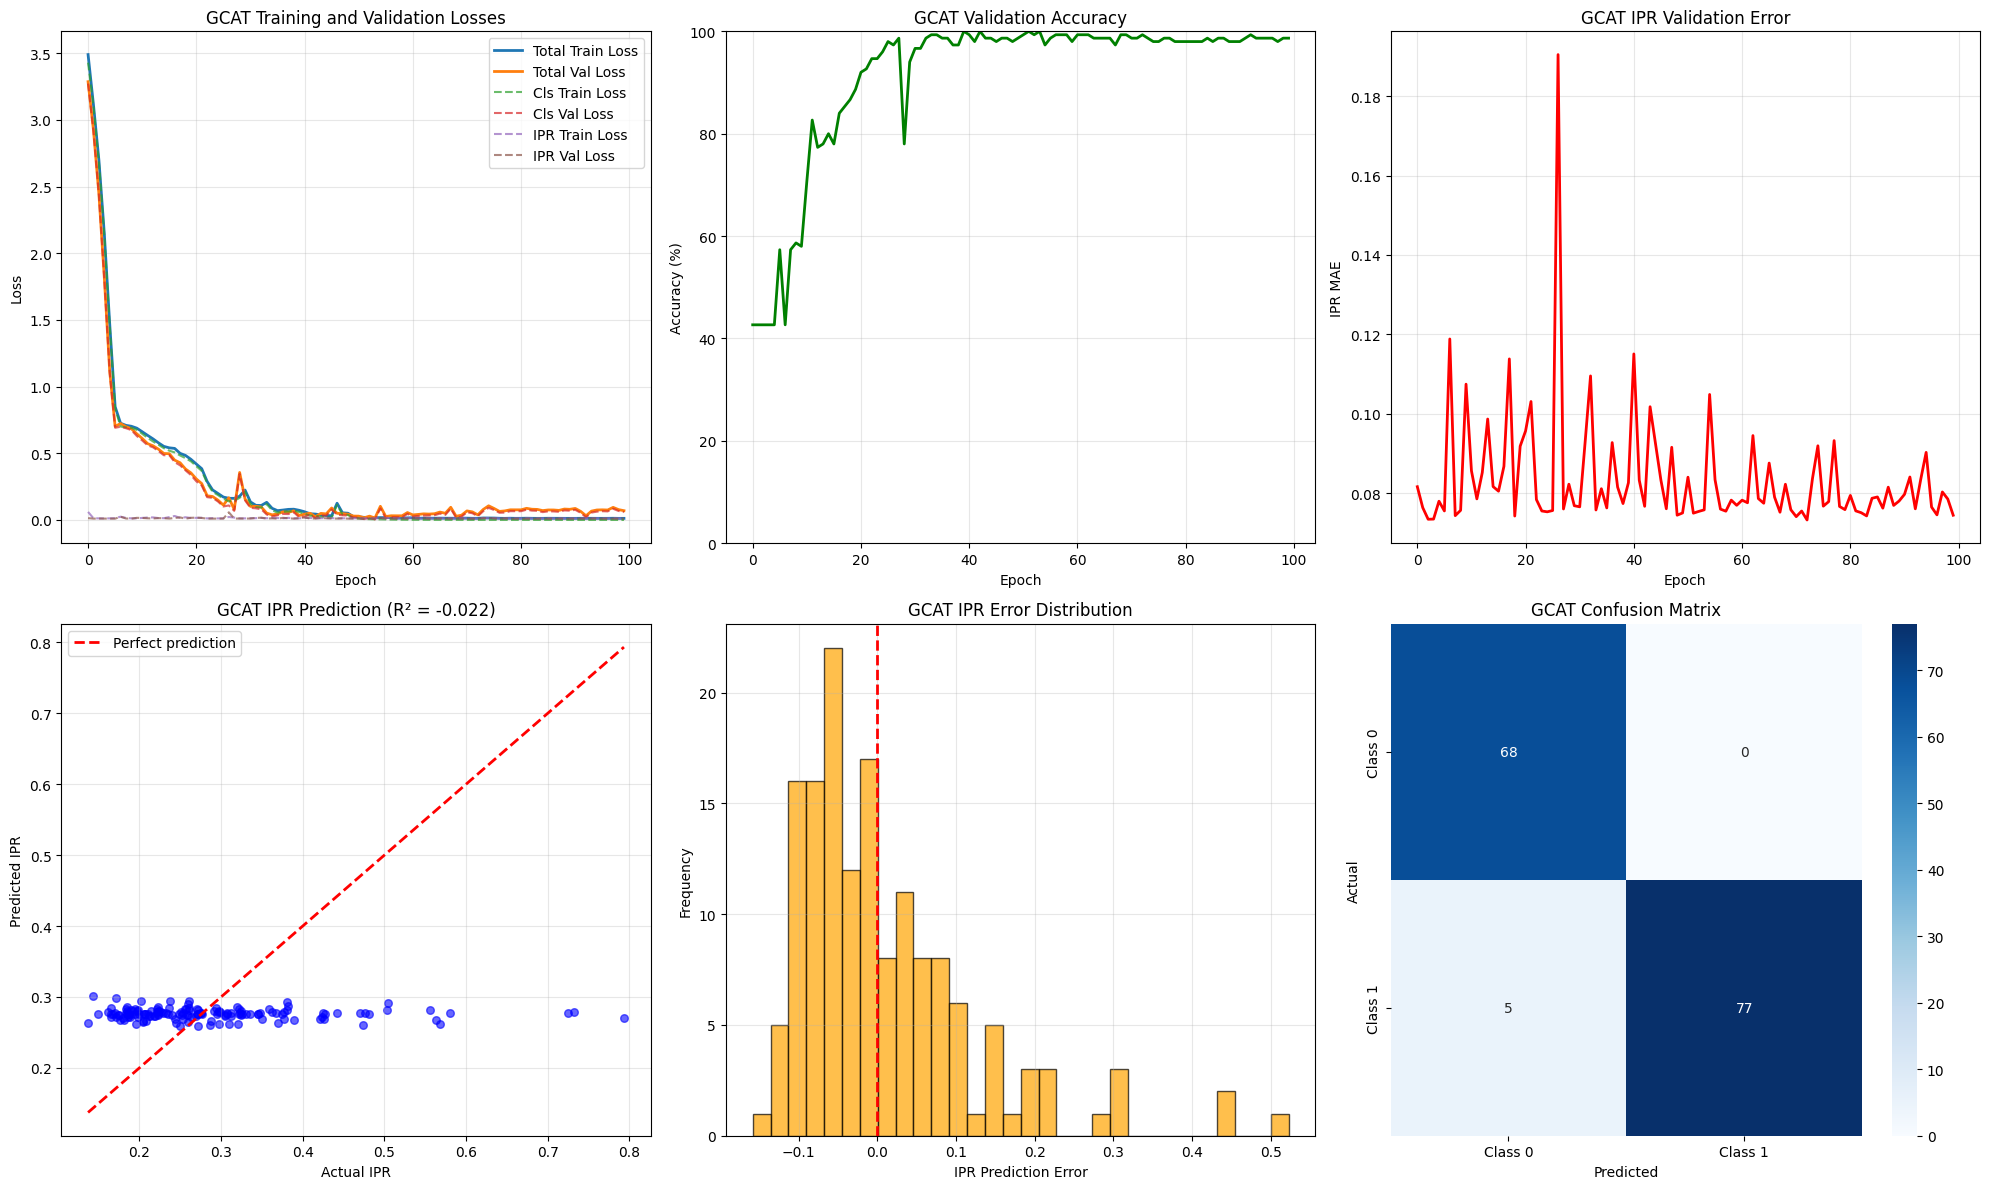


 GCAT DETAILED ANALYSIS:
Total samples: 150
IPR prediction range: [0.259, 0.301]
IPR actual range: [0.137, 0.793]
IPR error std: 0.1162

 GCAT results saved to 'gcat_model_results.pth'
 GCAT plot saved to 'gcat_model_results.png'


In [33]:
## Execution Block for GCAT GNN ##
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix
if __name__ == "__main__":
    # Set parameters
    n_nodes = 10
    n_features = 8
    n_classes = 2
    n_samples = 1000
    batch_size = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Using device: {device}")

    # Create dataset
    dataset = StarNetworkDataset(n_samples=n_samples, n_nodes=n_nodes,
                             n_features=n_features, n_classes=n_classes)

    # Split dataset
    train_size = int(0.7 * n_samples)
    val_size = int(0.15 * n_samples)
    test_size = n_samples - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Create adjacency matrix
    adj_matrix = create_star_network(n_nodes)

    # GCAT Model configuration
    model_config = {
        'dimNodeSignals': [n_features, 64, 32, 16, 8],  # Input, Hidden1, Hidden2, Output
        'nFilterTaps': [4, 2, 2, 2],                    # Filter taps for each layer
        'nAttentionHeads': [4, 2, 1, 1],                # Attention heads for each layer
        'bias': True,
        'nonlinearity': nn.ReLU,
        'nSelectedNodes': [50, 25, 10, 5],              # Nodes after each pooling
        'poolingFunction': AveragePooling,
        'poolingSize': [2, 2, 2, 2],                    # Pooling size for each layer
        'dimLayersMLP': [64, 32],                    # MLP layers after GCAT
        'dimLayersIPR': [16, 8],                     # IPR regression layers
        'GSO': adj_matrix,
        'order': 'Degree'
    }

    # Initialize GCAT model
    model = GraphConvolutionAttentionalNetwork(**model_config)
    model = model.double()
    model = model.to(device)

    print(f"GCAT Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Loss functions and optimizer
    criterion_cls = nn.CrossEntropyLoss()
    criterion_ipr = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Train the GCAT model
    print("Training GCAT model...")
    train_losses, val_losses, val_accuracies, val_ipr_errors = train_gcat_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion_cls=criterion_cls,
        criterion_ipr=criterion_ipr,
        epochs=100,
        device=device,
        cls_weight=1.0,
        ipr_weight=0.8
    )

    # Evaluate on test set
    print("\nEvaluating GCAT model on test set...")
    test_results = evaluate_gcat_model(
        model=model,
        test_loader=test_loader,
        device=device
    )

    # Print results
    print(f"\n{'='*50}")
    print("GCAT MODEL - FINAL RESULTS")
    print(f"{'='*50}")

    print(f"\n CLASSIFICATION METRICS:")
    print(f"Accuracy: {test_results['accuracy']:.4f}")
    print(f"F1 Score: {test_results['f1_score']:.4f}")
    print(f"Precision: {test_results['precision']:.4f}")
    print(f"Recall: {test_results['recall']:.4f}")

    print(f"\n IPR REGRESSION METRICS:")
    print(f"MAE: {test_results['ipr_mae']:.4f}")
    print(f"RMSE: {test_results['ipr_rmse']:.4f}")
    print(f"R² Score: {test_results['ipr_r2']:.4f}")
    print(f"Correlation: {test_results['ipr_correlation']:.4f}")

    # Generate comprehensive plots
    print("\nGenerating plots...")
    plt.figure(figsize=(20, 12))

    # Plot 1: Training and Validation Losses
    plt.subplot(2, 3, 1)
    plt.plot(train_losses['total'], label='Total Train Loss', linewidth=2)
    plt.plot(val_losses['total'], label='Total Val Loss', linewidth=2)
    plt.plot(train_losses['cls'], '--', label='Cls Train Loss', alpha=0.7)
    plt.plot(val_losses['cls'], '--', label='Cls Val Loss', alpha=0.7)
    plt.plot(train_losses['ipr'], '--', label='IPR Train Loss', alpha=0.7)
    plt.plot(val_losses['ipr'], '--', label='IPR Val Loss', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GCAT Training and Validation Losses')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Validation Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(val_accuracies, 'g-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('GCAT Validation Accuracy')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)

    # Plot 3: IPR Validation Error
    plt.subplot(2, 3, 3)
    plt.plot(val_ipr_errors, 'r-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('IPR MAE')
    plt.title('GCAT IPR Validation Error')
    plt.grid(True, alpha=0.3)

    # Plot 4: IPR Predictions vs Actual
    plt.subplot(2, 3, 4)
    plt.scatter(test_results['ipr_actuals'], test_results['ipr_predictions'],
                alpha=0.6, s=30, c='blue')
    min_val = min(np.min(test_results['ipr_actuals']), np.min(test_results['ipr_predictions']))
    max_val = max(np.max(test_results['ipr_actuals']), np.max(test_results['ipr_predictions']))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
    plt.xlabel('Actual IPR')
    plt.ylabel('Predicted IPR')
    plt.title(f'GCAT IPR Prediction (R² = {test_results["ipr_r2"]:.3f})')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 5: IPR Error Distribution
    plt.subplot(2, 3, 5)
    ipr_errors = test_results['ipr_actuals'] - test_results['ipr_predictions']
    plt.hist(ipr_errors, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel('IPR Prediction Error')
    plt.ylabel('Frequency')
    plt.title('GCAT IPR Error Distribution')
    plt.grid(True, alpha=0.3)

    # Plot 6: Confusion Matrix
    plt.subplot(2, 3, 6)
    cm = confusion_matrix(test_results['labels'], test_results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('GCAT Confusion Matrix')

    plt.tight_layout()
    plt.savefig('gcat_model_results_star_layer_3.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Additional analysis
    print(f"\n GCAT DETAILED ANALYSIS:")
    print(f"Total samples: {test_results['total_samples']}")
    print(f"IPR prediction range: [{test_results['ipr_predictions'].min():.3f}, {test_results['ipr_predictions'].max():.3f}]")
    print(f"IPR actual range: [{test_results['ipr_actuals'].min():.3f}, {test_results['ipr_actuals'].max():.3f}]")
    print(f"IPR error std: {np.std(ipr_errors):.4f}")

    # Save results
    results_dict = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'val_ipr_errors': val_ipr_errors,
        'test_results': test_results,
        'model_config': model_config
    }

    torch.save({
        'model_state_dict': model.state_dict(),
        'results': results_dict
    }, 'gcat_model_results.pth')

    print(f"\n GCAT results saved to 'gcat_model_results.pth'")
    print(f" GCAT plot saved to 'gcat_model_results.png'")